In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import re
from PIL import Image

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tarfile

tar_gz_file_path = "/content/drive/MyDrive/Datas/aclImdb_v1.tar.gz"
extraction_directory = '/content/'

In [4]:
with tarfile.open(tar_gz_file_path, 'r:gz') as tar_ref:
    tar_ref.extractall(extraction_directory)

In [5]:
import os
path_to_data = "/content/aclImdb/train"

path_to_pos_fld = os.path.join(path_to_data, "pos")
path_to_neg_fld = os.path.join(path_to_data, "neg")

In [6]:
path_to_pos_fld, path_to_neg_fld

('/content/aclImdb/train/pos', '/content/aclImdb/train/neg')

In [7]:
path_to_pos_txt = [os.path.join(path_to_pos_fld, file) for file in os.listdir(path_to_pos_fld)]
path_to_neg_txt = [os.path.join(path_to_neg_fld, file) for file in os.listdir(path_to_neg_fld)]

In [8]:
training_file = path_to_pos_txt + path_to_neg_txt

## **Tokenizer**

In [9]:
all_text = []
len_txt = []

for file in training_file:
  with open(file, 'r') as f:
    text = f.readline().lower()
  text = re.sub(r"[^\w\s]", "", text)
  text = text.split(" ")
  text = [word for word in text if (word not in stopwords) and (len(word) > 0)]

  len_txt.append(len(text))
  all_text += text

unique_text = dict(Counter(all_text))
words = sorted([key for (key, value) in unique_text.items() if value > 500])

words.append("<UNK>")
words.append("<PAD>")

In [10]:
word_to_idx = {word: idx for idx, word in enumerate(words)}
idx_to_word = {idx: word for idx, word in enumerate(words)}

## **Dataset & DataLoaders**

In [11]:
class IMDBDataset(Dataset):
  def __init__(self, path_to_data, word_to_idx, max_seq_len = 200):
    path_to_pos = os.path.join(path_to_data, "pos")
    path_to_neg = os.path.join(path_to_data, "neg")

    path_to_pos_txt = [os.path.join(path_to_pos, file) for file in os.listdir(path_to_pos)]
    path_to_neg_txt = [os.path.join(path_to_neg, file) for file in os.listdir(path_to_neg)]

    self.training_file = path_to_pos_txt + path_to_neg_txt
    self.tokenizer = word_to_idx
    self.max_len = max_seq_len

  def __len__(self):
    return len(self.training_file)

  def __getitem__(self, idx):
    path_to_txt = self.training_file[idx]

    with open(path_to_txt, 'r') as f:
      txt = f.readline().lower()
    text = re.sub(r"[^\w\s]", "", txt)
    text = text.split(" ")
    text = [word for word in text if (word not in stopwords) and (len(word) > 0)]

    tokenized = []
    for word in text:
      if word in self.tokenizer.keys():
        tokenized.append(self.tokenizer[word])
      else:
        tokenized.append(self.tokenizer["<UNK>"])

    sample = torch.tensor(tokenized)

    if len(sample) > self.max_len:
      diff = len(sample) - self.max_len
      start_idx = np.random.randint(diff)
      sample = sample[start_idx:start_idx + self.max_len]

    if "neg" in path_to_txt:
      label = 0
    else:
      label = 1

    return sample, label

In [12]:
dataset = IMDBDataset(path_to_data, word_to_idx)

In [13]:
for sample, label in dataset:
  print(sample, label)
  break

tensor([139, 600, 255, 776, 342, 733,  10, 989, 989, 989, 989, 957, 568, 989,
        989, 989, 989, 989, 989, 989, 989, 266, 989, 161, 989, 989, 989, 989,
        989, 192, 147, 140, 264, 989, 984, 392]) 1


In [14]:
dataloader = DataLoader(dataset, batch_size = 4 )

In [15]:
for sample in dataloader:
  print(sample)
  break

RuntimeError: stack expects each tensor to be equal size, but got [36] at entry 0 and [200] at entry 1

In [16]:
def data_collator(batch):
  texts, labels = [], []

  for text, label in batch:
    texts.append(text)
    labels.append(label)

  labels = torch.tensor(labels)
  texts = nn.utils.rnn.pad_sequence(texts, batch_first = True, padding_value = word_to_idx["<PAD>"])
  # print(texts)

  return texts, labels

In [17]:
dataloader = DataLoader(dataset, batch_size = 4, collate_fn = data_collator, shuffle = True)

In [18]:
for text, label in dataloader:
  print(text.shape)
  print(label.shape)
  break

torch.Size([4, 200])
torch.Size([4])


In [19]:
batch_size = 5
sequence_length = 15
input_size = 10
hidden_size = 20
num_layers = 2

In [20]:
lstm = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)

rand = torch.rand(batch_size, sequence_length, input_size)

In [21]:
rand.shape

torch.Size([5, 15, 10])

In [22]:
output, (hn, cn) = lstm(rand)

In [23]:
print(output.shape)

torch.Size([5, 15, 20])


In [24]:
hn.shape, cn.shape

(torch.Size([5, 20]), torch.Size([5, 20]))

In [25]:
output[0][-1]

tensor([-0.0080, -0.3110,  0.6275,  0.0207, -0.0354,  0.3756,  0.3110, -0.3418,
        -0.0112,  0.1914, -0.2535,  0.0216,  0.2037, -0.1884,  0.3309, -0.2834,
        -0.0105, -0.3940, -0.3532,  0.2103], grad_fn=<SelectBackward0>)

In [36]:
class LSTMNet(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes):
    super().__init__()

    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes

    # Embedding matrix
    self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

    # LSTM
    self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first=True)
    self.dropout = nn.Dropout(0.2)

    self.fc = nn.Linear(self.hidden_size, self.num_classes)

  def forward(self, x):
    batch_size, seq_len = x.shape
    embeddings = self.embedding(x)

    h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
    c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

    output, (hn, cn) = self.lstm(embeddings, (h0, c0))

    last_hidden = output[:, -1, :]

    output = self.dropout(last_hidden)

    output = self.fc(output)

    return output

## **Training**

In [37]:
train_dataset = IMDBDataset(path_to_data, word_to_idx)
test_dataset = IMDBDataset("/content/aclImdb/test", word_to_idx)

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [39]:
model = LSTMNet(vocab_size = len(word_to_idx),
                embedding_dim=120,
                hidden_size=256,
                num_layers = 1,
                num_classes=2).to(device)

In [40]:
model

LSTMNet(
  (embedding): Embedding(991, 120)
  (lstm): LSTM(120, 256, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [41]:
epochs = 15
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size = batch_size, collate_fn = data_collator, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, collate_fn = data_collator, shuffle = False)

In [42]:
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7ab4d012cb90>,
 <torch.utils.data.dataloader.DataLoader at 0x7ab4de351010>)

In [43]:
def train(model, device, epochs, optimizer, loss_fn, train_loader, test_loader):
  log_training = {"epoch": [],
                  "training_loss": [],
                  "training_acc": [],
                  "testing_loss": [],
                  "testing_acc": []}
  for epoch in range(1, epochs + 1):
    print(f"Starting Epoch: {epoch}")
    training_loss, training_acc = [], []
    testing_loss, testing_acc = [], []

    # Training
    model.train()
    for text, label in tqdm(train_loader):
      text, label = text.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(text)

      # Loss
      loss = loss_fn(output, label)
      training_loss.append(loss.item())

      # Accuracy
      prediction = torch.argmax(output, axis = 1)
      accuracy = torch.sum(prediction == label) / len(prediction)
      training_acc.append(accuracy.item())

      # Backprop
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 5)
      optimizer.step()

    # Testing
    model.eval()
    for text, label in tqdm(test_loader):
      text, label = text.to(device), label.to(device)
      with torch.no_grad():
        output = model(text)

        # Loss
        loss = loss_fn(output, label)
        testing_loss.append(loss.item())

        # Accuracy
        prediction = torch.argmax(output, axis = 1)
        accuracy = torch.sum(prediction == label) / len(prediction)
        testing_acc.append(accuracy.item())

    training_loss_mean, training_acc_mean = np.mean(training_loss), np.mean(training_acc)
    testing_loss_mean, testing_acc_mean = np.mean(testing_loss), np.mean(testing_acc)

    log_training["epoch"].append(epoch)
    log_training["training_loss"].append(training_loss_mean)
    log_training["training_acc"].append(training_acc_mean)
    log_training["testing_loss"].append(testing_loss_mean)
    log_training["testing_acc"].append(testing_acc_mean)

    print(f"Training Loss: {training_loss_mean}")
    print(f"Training Acc: {training_acc_mean}")
    print(f"Testing Loss: {testing_loss_mean}")
    print(f"Testing Acc: {testing_acc_mean}")

  return log_training, model

In [44]:
training_log, model = train(model, device, epochs, optimizer, loss_fn, train_loader, test_loader)

Starting Epoch: 1


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.6942612309845126
Training Acc: 0.5072544642857143
Testing Loss: 0.6931368191631473
Testing Acc: 0.5072943239795918
Starting Epoch: 2


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.6915436073833582
Training Acc: 0.5123724490404129
Testing Loss: 0.6902004550306164
Testing Acc: 0.5115752551058421
Starting Epoch: 3


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.6860935499473494
Training Acc: 0.5220424107142857
Testing Loss: 0.6802649029663631
Testing Acc: 0.5396843111636688
Starting Epoch: 4


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.5019058972901228
Training Acc: 0.7600685586126483
Testing Loss: 0.4156732007252927
Testing Acc: 0.8138950892857143
Starting Epoch: 5


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.37211269155448795
Training Acc: 0.8410315689991932
Testing Loss: 0.352668436890354
Testing Acc: 0.8441964287538918
Starting Epoch: 6


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.32631682209214385
Training Acc: 0.8633211096938775
Testing Loss: 0.3484484177767014
Testing Acc: 0.8449298468779545
Starting Epoch: 7


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.2961035715986271
Training Acc: 0.8775430485910299
Testing Loss: 0.3510216558162047
Testing Acc: 0.8448501274901994
Starting Epoch: 8


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.26217473150059883
Training Acc: 0.8945232781828666
Testing Loss: 0.3519827509869118
Testing Acc: 0.8487563774901994
Starting Epoch: 9


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.2235804272777572
Training Acc: 0.9122528698371382
Testing Loss: 0.37302266494656094
Testing Acc: 0.8459263392248932
Starting Epoch: 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.18433777664845086
Training Acc: 0.9318399234693877
Testing Loss: 0.420722664010768
Testing Acc: 0.8433434312440911
Starting Epoch: 11


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.15013950057707878
Training Acc: 0.9468750001824632
Testing Loss: 0.47002300004265746
Testing Acc: 0.8372209823253204
Starting Epoch: 12


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.11910331199819944
Training Acc: 0.9597098216110346
Testing Loss: 0.5445206061917909
Testing Acc: 0.8276147961008306
Starting Epoch: 13


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.10366196583538335
Training Acc: 0.9651227678571429
Testing Loss: 0.6049931659078112
Testing Acc: 0.8324298469387755
Starting Epoch: 14


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.08995775327238502
Training Acc: 0.9708227040816326
Testing Loss: 0.5988936304894029
Testing Acc: 0.8375558035106075
Starting Epoch: 15


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Training Loss: 0.07670516519788273
Training Acc: 0.9754065688775511
Testing Loss: 0.6512663671556784
Testing Acc: 0.8325892857142857


In [45]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

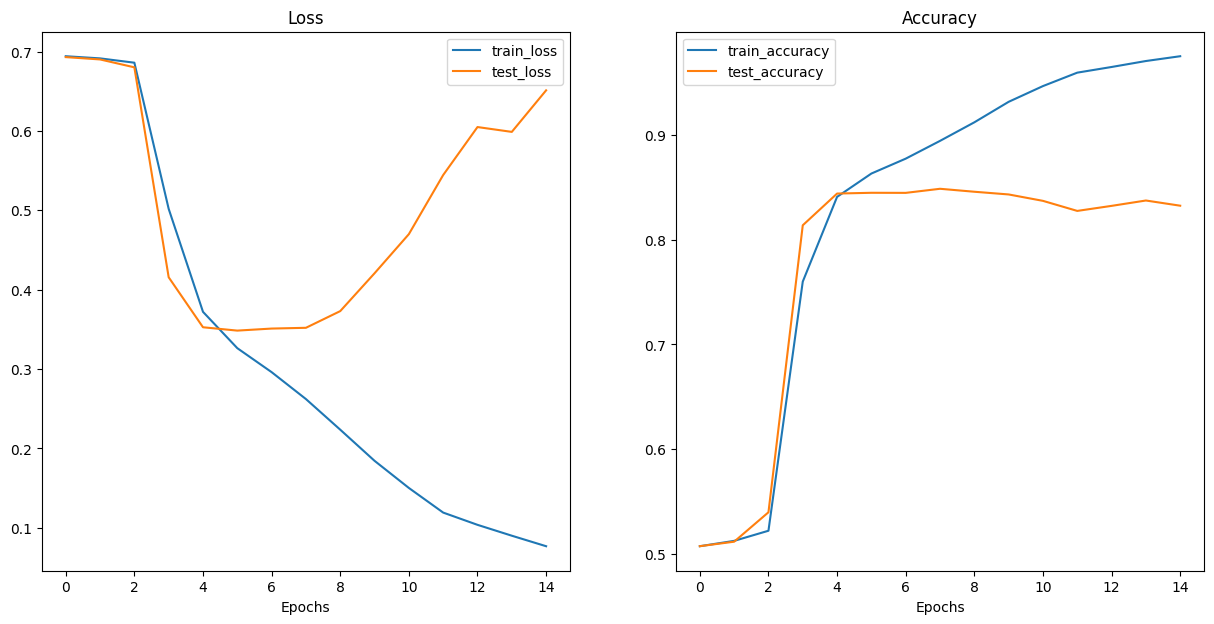

In [56]:
loss = training_log["training_loss"]
test_loss = training_log["testing_loss"]

accuracy = training_log["training_acc"]
test_accuracy = training_log["testing_acc"]

results = {"train_loss": loss, "test_loss": test_loss, "train_acc": accuracy, "test_acc": test_accuracy}

plot_loss_curves(results)

In [74]:
def predict(model, device, text, word_to_idx, max_seq_len = 200):
  model.eval()
  with torch.no_grad():
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = text.split(" ")
    text = [word for word in text if (word not in stopwords) and (len(word) > 0)]

    # Tokenize and convert to tensor
    tokenized = []
    for word in text:
      if word in word_to_idx.keys():
        tokenized.append(word_to_idx[word])
      else:
        tokenized.append(word_to_idx["<UNK>"])

    sample = torch.tensor(tokenized)

    if len(sample) > max_seq_len:
      sample = sample[:max_seq_len]

    # Add batch dimension and move to device
    sample = sample.unsqueeze(0).to(device)

    # Model output &  Prediction
    output = model(sample)
    prediction = torch.argmax(output, axis = 1).item()

    if prediction > 0.5:
      return "Positive"
    else:
      return "Negative"

In [75]:
example_text = "This movie was amazing!, I loved the movie"
predicted_sentiment = predict(model, device, example_text, word_to_idx)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Positive


In [76]:
text = "The movie was dog shit, I hated every scene in the movie, time waste"
predicted_sentiment = predict(model, device, text, word_to_idx)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: Negative
